<a href="https://colab.research.google.com/github/Nanak011/mlpc_ia/blob/main/individualassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import time
import re

# Install necessary libraries
!pip install scikit-learn tensorflow matplotlib

# Try to import tensorflow for GPU check
try:
    import tensorflow as tf
    # Check if GPU is available
    if tf.config.list_physical_devices("GPU"):
        print("GPU is available.")
        gpu_available = True
    else:
        print("GPU is not available, using CPU.")
        gpu_available = False
except ImportError:
    print("TensorFlow not installed, using CPU.")
    gpu_available = False

# Load the dataset
df = pd.read_csv("1- cumulative-area-burnt-by-wildfires-by-week.csv")

# Identify columns with wildfire data (years 2012-2024)
wildfire_columns = [col for col in df.columns if 'Cumulative area burnt by wildfires in' in col and any(str(year) in col for year in range(2012, 2025))]

# Keep only relevant columns
df_wildfire = df[['Entity', 'Code'] + wildfire_columns]

# Reshape data from wide to long format
df_long = df_wildfire.melt(id_vars=['Entity', 'Code'], var_name='Year_Column', value_name='AreaBurned')

# Extract year from column names using regex
df_long['Year'] = df_long['Year_Column'].str.extract(r'(\d{4})').astype(int)

# Convert 'AreaBurned' to numeric, coercing errors to NaN
df_long['AreaBurned'] = pd.to_numeric(df_long['AreaBurned'], errors='coerce')

# Remove rows where AreaBurned is 0 or missing
df_cleaned = df_long[(df_long['AreaBurned'].notna()) & (df_long['AreaBurned'] > 0)].copy()

# Display the first few rows of the cleaned data
print('Cleaned Data Head:')
print(df_cleaned.head())

GPU is available.
Cleaned Data Head:
        Entity Code                                 Year_Column  AreaBurned  \
0  Afghanistan  AFG  Cumulative area burnt by wildfires in 2024       391.0   
1  Afghanistan  AFG  Cumulative area burnt by wildfires in 2024       559.0   
2  Afghanistan  AFG  Cumulative area burnt by wildfires in 2024       841.0   
3  Afghanistan  AFG  Cumulative area burnt by wildfires in 2024       841.0   
4  Afghanistan  AFG  Cumulative area burnt by wildfires in 2024       841.0   

   Year  
0  2024  
1  2024  
2  2024  
3  2024  
4  2024  


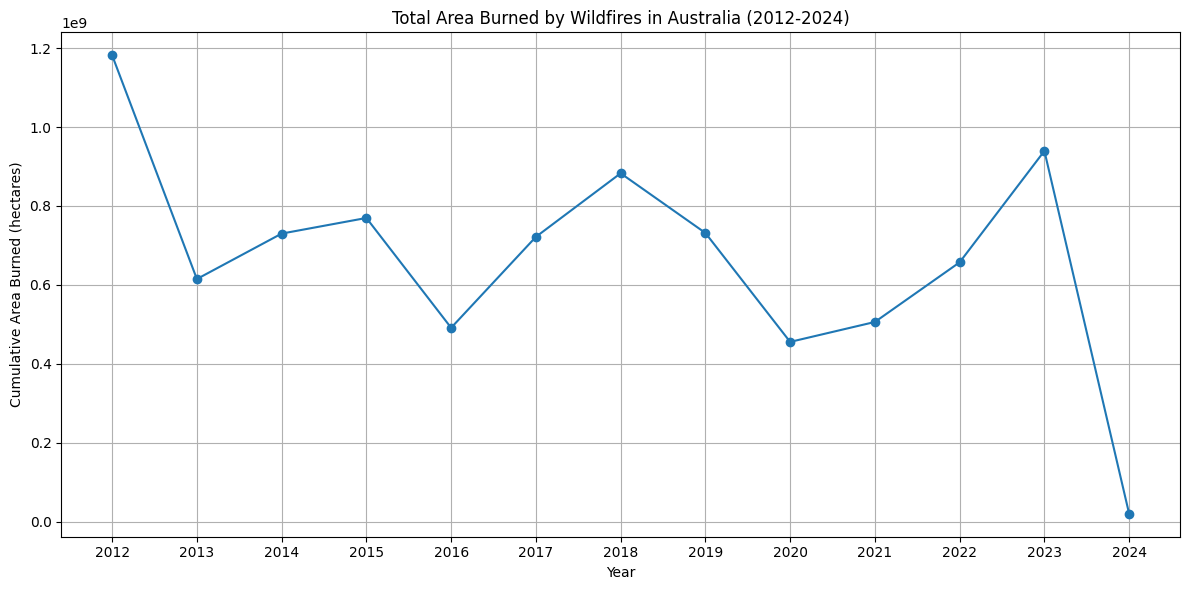

In [7]:
# Visualize total area burned for a selected country (e.g., Australia)
country_name = 'Australia'
australia_data = df_cleaned[df_cleaned["Entity"] == country_name]

if not australia_data.empty:
    # Aggregate by year to get total area burned per year for the country
    australia_yearly_data = australia_data.groupby("Year")["AreaBurned"].sum().reset_index()

    plt.figure(figsize=(12, 6))
    plt.plot(australia_yearly_data["Year"], australia_yearly_data["AreaBurned"], marker='o')
    plt.title(f'Total Area Burned by Wildfires in {country_name} (2012-2024)')
    plt.xlabel('Year')
    plt.ylabel('Cumulative Area Burned (hectares)')
    plt.grid(True)
    plt.xticks(australia_yearly_data["Year"].unique())
    plt.tight_layout()
    plt.show()
else:
    print(f'No data found for {country_name}.')


In [10]:
# Machine Learning Preparation

# For simplicity, let's use \'Year\' as the feature and \'AreaBurned\' as the target.
# In a real scenario, more features would be engineered (e.g., historical averages, climate data).
X = df_cleaned[["Year"]]
y = df_cleaned["AreaBurned"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('\nData Split Shapes:')
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


Data Split Shapes:
X_train shape: (85257, 1)
X_test shape: (21315, 1)
y_train shape: (85257,)
y_test shape: (21315,)



Training Linear Regression on CPU...
Linear Regression - CPU Training Time: 0.0234 seconds

Training Linear Regression on GPU...
Linear Regression - GPU Training Time: 0.0035 seconds
Linear Regression - R2 Score: -0.0002, RMSE: 20041133.00

Training Random Forest Regressor on CPU...
Random Forest Regressor - CPU Training Time: 1.4251 seconds

Training Random Forest Regressor on GPU...
Random Forest Regressor - GPU Training Time: 1.3315 seconds
Random Forest Regressor - R2 Score: 0.0000, RMSE: 20038783.78


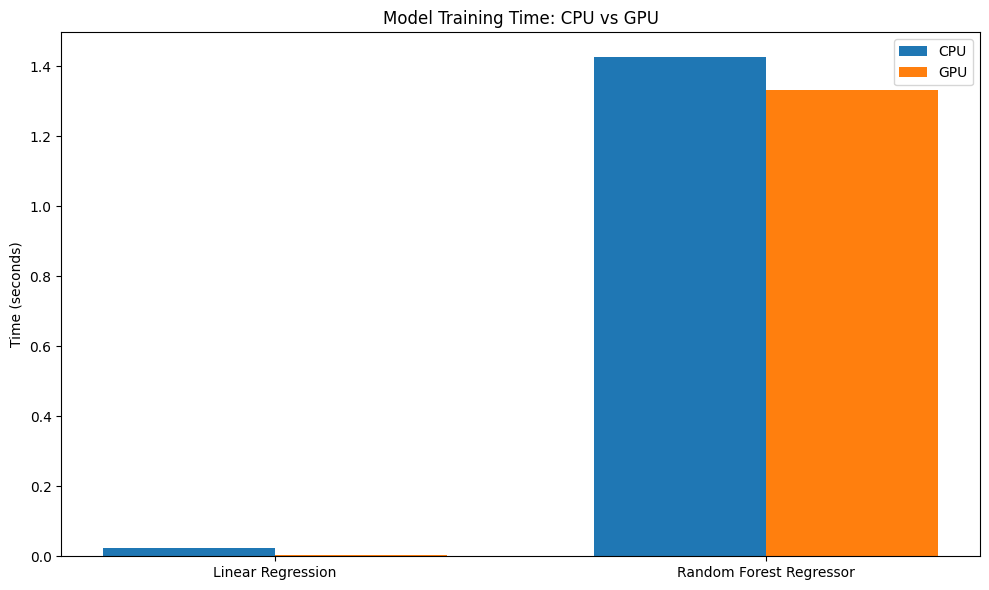

In [11]:
# Machine Learning Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_jobs=-1, random_state=42)
}

results = {}

# Explicit CPU vs GPU comparison
training_times_comparison = {}

for name, model in models.items():
    training_times_comparison[name] = {'CPU': 0, 'GPU': 0}

    # Run on CPU
    print(f'\nTraining {name} on CPU...')
    with tf.device('/CPU:0'):
        start_time_cpu = time.time()
        model.fit(X_train, y_train)
        end_time_cpu = time.time()
        training_time_cpu = end_time_cpu - start_time_cpu
        training_times_comparison[name]['CPU'] = training_time_cpu
        print(f'{name} - CPU Training Time: {training_time_cpu:.4f} seconds')

    # Run on GPU if available
    if gpu_available:
        print(f'\nTraining {name} on GPU...')
        with tf.device('/GPU:0'):
            start_time_gpu = time.time()
            # Re-initialize model for GPU training to ensure a clean slate
            if name == 'Linear Regression':
                model_gpu = LinearRegression()
            elif name == 'Random Forest Regressor':
                model_gpu = RandomForestRegressor(n_jobs=-1, random_state=42)
            model_gpu.fit(X_train, y_train)
            end_time_gpu = time.time()
            training_time_gpu = end_time_gpu - start_time_gpu
            training_times_comparison[name]['GPU'] = training_time_gpu
            print(f'{name} - GPU Training Time: {training_time_gpu:.4f} seconds')

    # Evaluate model (using the last trained model, which would be GPU if available, else CPU)
    # Note: For a fair comparison, you might want to evaluate the CPU-trained model separately
    # For simplicity here, we evaluate the model that was last trained (GPU if available, else CPU)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[name] = {
        'R2 Score': r2,
        'RMSE': rmse,
        'Predictions': y_pred
    }
    print(f'{name} - R2 Score: {r2:.4f}, RMSE: {rmse:.2f}')

# Plotting Training Times (CPU vs GPU)
labels = list(training_times_comparison.keys())
cpu_times = [training_times_comparison[model]['CPU'] for model in labels]
gpu_times = [training_times_comparison[model]['GPU'] if gpu_available else 0 for model in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, cpu_times, width, label='CPU')
if gpu_available:
    rects2 = ax.bar(x + width/2, gpu_times, width, label='GPU')

ax.set_ylabel('Time (seconds)')
ax.set_title('Model Training Time: CPU vs GPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()



Linear Regression Classification Metrics (Threshold > 10000 ha):
  FPR: 1.0000
  FNR: 0.0000
  Accuracy: 0.6280
  Precision: 0.6280
  Recall: 1.0000
  F1-Score: 0.7715
  Confusion Matrix:
[[    0  7930]
 [    0 13385]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7930
           1       0.63      1.00      0.77     13385

    accuracy                           0.63     21315
   macro avg       0.31      0.50      0.39     21315
weighted avg       0.39      0.63      0.48     21315


Random Forest Regressor Classification Metrics (Threshold > 10000 ha):
  FPR: 1.0000
  FNR: 0.0000
  Accuracy: 0.6280
  Precision: 0.6280
  Recall: 1.0000
  F1-Score: 0.7715
  Confusion Matrix:
[[    0  7930]
 [    0 13385]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7930
           1       0.63      1.00      0.77     13385

    accuracy 

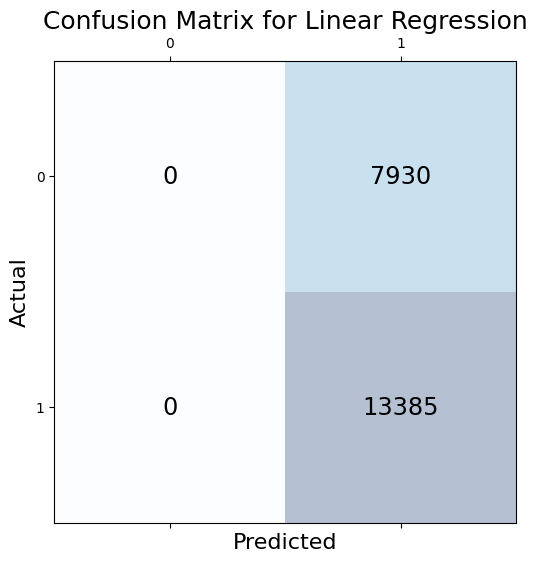

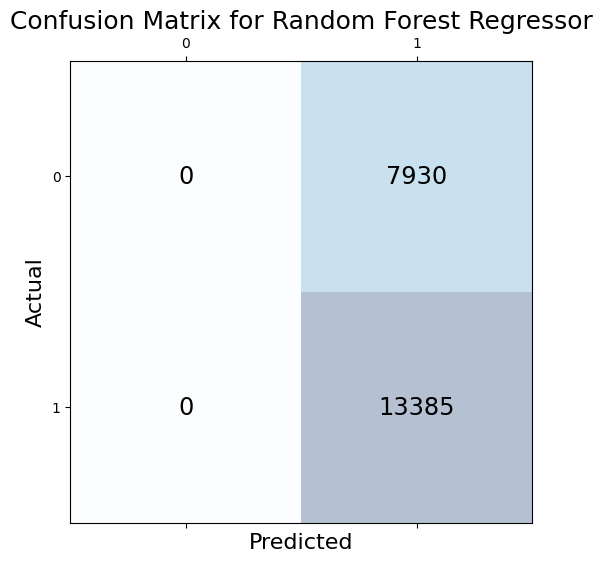

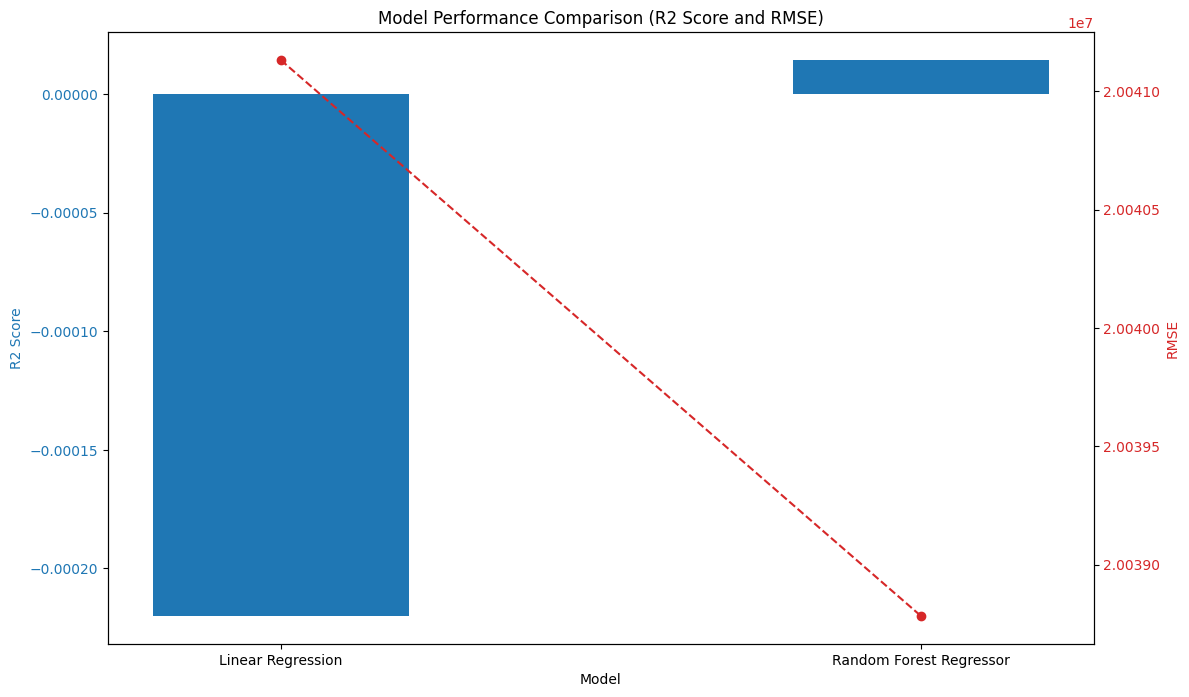

In [13]:
# Classification for False Positive/Negative Rates
threshold = 10000  # hectares

# Convert regression problem to classification problem based on threshold
y_true_class = (y_test > threshold).astype(int)

for name, res in results.items():
    y_pred_class = (res["Predictions"] > threshold).astype(int)

    cm = confusion_matrix(y_true_class, y_pred_class)
    tn, fp, fn, tp = cm.ravel()

    # False Positive Rate (FPR): FP / (FP + TN)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    # False Negative Rate (FNR): FN / (FN + TP)
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

    accuracy = accuracy_score(y_true_class, y_pred_class)
    precision = precision_score(y_true_class, y_pred_class, zero_division=0)
    recall = recall_score(y_true_class, y_true_class, zero_division=0)
    f1 = f1_score(y_true_class, y_pred_class, zero_division=0)

    results[name]["FPR"] = fpr
    results[name]["FNR"] = fnr
    results[name]["Accuracy"] = accuracy
    results[name]["Precision"] = precision
    results[name]["Recall"] = recall
    results[name]["F1-Score"] = f1
    results[name]["Confusion Matrix"] = cm

    print(f"\n{name} Classification Metrics (Threshold > {threshold} ha):")
    print(f"  FPR: {fpr:.4f}")
    print(f"  FNR: {fnr:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print("  Confusion Matrix:")
    print(cm)
    print("  Classification Report:")
    print(classification_report(y_true_class, y_pred_class, zero_division=0))

# Performance Metrics and Comparison
print('\n--- Model Performance Comparison ---')
performance_data = []
for name, res in results.items():
    prediction_rate = np.mean(res["Predictions"] > threshold) # Example prediction rate
    std_dev_predictions = np.std(res["Predictions"])

    performance_data.append({
        "Model": name,
        "R2 Score": res["R2 Score"],
        "RMSE": res["RMSE"],
        "CPU Training Time (s)": training_times_comparison[name]["CPU"],
        "GPU Training Time (s)": training_times_comparison[name]["GPU"] if gpu_available else "N/A",
        "Accuracy": res["Accuracy"],
        "FPR": res["FPR"],
        "FNR": res["FNR"],
        "Prediction Rate": prediction_rate,
        "Std Dev Predictions": std_dev_predictions
    })

performance_df = pd.DataFrame(performance_data)
print(performance_df.to_string())

# Plotting Confusion Matrices
for name, res in results.items():
    cm = res["Confusion Matrix"]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title(f'Confusion Matrix for {name}' , fontsize=18)
    plt.show()

# Model Performance Comparison Plot (R2 and RMSE)
fig, ax1 = plt.subplots(figsize=(12, 7))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('R2 Score', color=color)
ax1.bar(performance_df['Model'], performance_df['R2 Score'], color=color, width=0.4)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
ax2.plot(performance_df['Model'], performance_df['RMSE'], color=color, marker='o', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Model Performance Comparison (R2 Score and RMSE)')
plt.show()

In [17]:
import statsmodels.api as sm

# Add a constant to the independent variable for OLS regression
X_ols = sm.add_constant(X_train)

# Create and fit the OLS model
ols_model = sm.OLS(y_train, X_ols)
ols_results = ols_model.fit()

# Print the OLS summary
print("\n--- OLS Regression Results (Linear Regression) ---")
print(ols_results.summary())



--- OLS Regression Results (Linear Regression) ---
                            OLS Regression Results                            
Dep. Variable:             AreaBurned   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.982
Date:                Wed, 16 Jul 2025   Prob (F-statistic):            0.00473
Time:                        14:48:27   Log-Likelihood:            -1.5570e+06
No. Observations:               85257   AIC:                         3.114e+06
Df Residuals:                   85255   BIC:                         3.114e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
